# Performance showcase of added "to_sql" functionality in mlinspect

Here the performance of the proposed inspection using sql will be compared to the original one in pandas. Part of
the "healthcare" and "compas" pipeline will be used.

## Required packages:
See: requirements/requirements.txt and requirements/requirements.dev.txt

## Some parameters you might want to set:

No handles with labels found to put in legend.


ImportError: attempted relative import with no known parent package

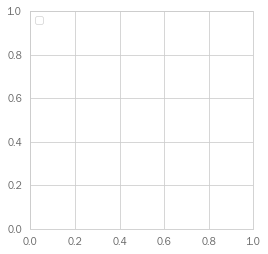

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import time

import timeit
from inspect import cleandoc
from mlinspect.utils import get_project_root
from _code_as_string import get_healthcare_pipe_code, get_compas_pipe_code, print_generated_code
from _benchmark_utility import plot_compare
import os

import numpy as np

from mlinspect.utils import get_project_root
import pandas as pd
from mlinspect import PipelineInspector, OperatorType
from mlinspect.inspections import HistogramForColumns, RowLineage, MaterializeFirstOutputRows
from mlinspect.checks import NoBiasIntroducedFor, NoIllegalFeatures
from demo.feature_overview.no_missing_embeddings import NoMissingEmbeddings
from inspect import cleandoc
from example_pipelines.healthcare import custom_monkeypatching
from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
import time
from IPython.display import display
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from ._benchmark_utility import UMBRA_PW, UMBRA_DB, UMBRA_PORT, UMBRA_HOST, UMBRA_USER, UMBRA_DIR,\
    POSTGRES_DB, POSTGRES_PW, POSTGRES_HOST, POSTGRES_USER, POSTGRES_PORT, \
    PLOT_DIR, DO_CLEANUP, MLINSPECT_ROOT_DIR, BENCH_REP


SIZES = [(10 ** i) for i in range(2, 5, 1)]

HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "healthcare", "healthcare.py")
COMPAS_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas.py")
ADULT_SIMPLE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "adult_simple", "adult_simple.py")
ADULT_COMPLEX_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "adult_complex",
                                     "adult_complex.py")

HEALTHCARE_BIAS = "[\'age_group\', \'race\']"
COMPAS_BIAS = "[\'sex\', \'race\']"

## Benchmark setup:

In [ ]:
def run_inspection(file_location, bias, to_sql, sql_one_run=False, dbms_connector=None, mode=None, materialize=None):
    from PIL import Image
    import matplotlib.pyplot as plt
    from mlinspect.visualisation import save_fig_to_path

    inspector_result = PipelineInspector \
        .on_pipeline_from_py_file(file_location) \
        .add_custom_monkey_patching_module(custom_monkeypatching) \
        .add_check(NoBiasIntroducedFor(bias)) \
        .add_check(NoIllegalFeatures()) \
        .add_check(NoMissingEmbeddings()) \
        .add_required_inspection(RowLineage(5)) \
        .add_required_inspection(MaterializeFirstOutputRows(5))

    if to_sql:
        inspector_result = inspector_result.execute_in_sql(dbms_connector=dbms_connector, sql_one_run=sql_one_run,
                                                           mode=mode, materialize=materialize, row_wise=False)
    else:
        inspector_result = inspector_result.execute()

    extracted_dag = inspector_result.dag
    filename = os.path.join(str(get_project_root()), "demo", "feature_overview", "healthcare.png")
    save_fig_to_path(extracted_dag, filename)
    im = Image.open(filename)
    plt.imshow(im)

    check_results = inspector_result.check_to_check_results
    no_bias_check_result = check_results[NoBiasIntroducedFor(["age_group", "race"])]

    distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(
        no_bias_check_result)
    result = ""
    result += distribution_changes_overview_df.to_markdown()

    for i in list(no_bias_check_result.bias_distribution_change.items()):
        _, join_distribution_changes = i
        for column, distribution_change in join_distribution_changes.items():
            result += "\n"
            result += f"\033[1m Column '{column}'\033[0m"
            result += distribution_change.before_and_after_df.to_markdown()

    print(result)
    return result

## Benchmark of default inspection using CTEs:

In [ ]:
umbra_path = r"/home/luca/Documents/Bachelorarbeit/umbra-students"
dbms_connector_u = UmbraConnector(dbname=UMBRA_DB, user=UMBRA_USER, password=UMBRA_PW, port=UMBRA_PORT, host=UMBRA_HOST,
                                  umbra_dir=UMBRA_DIR)

dbms_connector_p = PostgresqlConnector(dbname=POSTGRES_DB, user=POSTGRES_USER, password=POSTGRES_PW,
                                       port=POSTGRES_PORT, host=POSTGRES_HOST)

def run_for_all(file_location, bias, one_pass=False, mode="", materialize=None):
    t0 = time.time()
    run_inspection(to_sql=False)
    t1 = time.time()
    print("\nTime spend with original: " + str(t1 - t0))

    t0 = time.time()
    run_inspection(file_location=file_location, bias=bias, pto_sql=True, dbms_connector=dbms_connector_u, sql_one_run=one_pass, mode=mode, materialize=materialize)
    t1 = time.time()
    print("\nTime spend with modified SQL inspections: " + str(t1 - t0))

    t0 = time.time()
    run_inspection(file_location=file_location, bias=bias, to_sql=True, dbms_connector=dbms_connector_p, sql_one_run=one_pass, mode=mode, materialize=materialize)
    t1 = time.time()
    print("\nTime spend with modified SQL inspections: " + str(t1 - t0))


## Execute the inspections:

In [ ]:
run_for_all(HEALTHCARE_FILE_PY, HEALTHCARE_BIAS, one_pass=False, mode="", materialize=None)


In [ ]:
run_for_all(COMPAS_FILE_PY, HEALTHCARE_BIAS, one_pass=False, mode="", materialize=None)


## Benchmark of default inspection using MATERIALIZED VIEWs:

While doing the default inspection, parts of the generated code get executed multiple times. This is the reason
the option to MATERIALIZE Views, called more that once, got added. This way NO part of the pipeline is executed
more that ONCE.

In our case only postgres supports this option.

In [ ]:
pipeline_inspection_benchmark(HEALTHCARE_DATA_PATHS, healthcare_no_bias, mode="VIEW", materialize=True,
                              exclude_umbra=True, title="HealthcareInspectionComparisonVIEWMAT")


